In [1]:
# Import the necessities
from matplotlib import pyplot
import numpy as np
import os
import shutil
import caffe2
import caffe2.python.predictor.predictor_exporter as pe


from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])
print("Necessities imported!")

# If True, a more complicated convolutional model is used
# If False, a multilayer perceptron model is used
USE_LENET_MODEL = True

# Preps your image and test in a lmdb database(has been down)
data_folder = "/media/ygj/00030DB30006F338/ygj/dataset/caffe2_tutorial_data/mnist"
root_folder = "/home/ygj/caffe2/caffe2_notebooks/tutorial_files/tutorial_mnist"

Necessities imported!


In [3]:
##### Part1: the data input part(AddInput function)
def AddInput(model, batch_size, db, db_type):
    data_uint8, label = brew.db_input(
        model,
        blobs_out=["data_uint8", "label"],
        batch_size=batch_size,
        db=db,
        db_type=db_type)
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    data = model.Scale(data, data, scale=float(1./256))
    data = model.StopGradient(data, data)
    return data, label

# Part2: the main computation part (AddModel function)
def AddMLPModel(model, data):
    size = 28*28*1
    sizes = [size, size*2, size*2, 10]
    layer = data
    for i in range(len(sizes)-1):
        layer = brew.fc(model, layer, "dense_{}".format(i), sizes[i], sizes[i+1])
        if i != len(sizes)-1:
            layer = model.net.Relu(layer, "relu_{}".format(i))
    softmax = model.net.Softmax(layer, "softmax")
    return softmax

def AddLeNetModel(model, data):
    # Image size: 28*28->24*24
    conv1 = brew.conv(model, data, 'conv1', dim_in=1, dim_out=20, kernel=5)
    # Image size: 24*24->12*12
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel=2, stride=2)
    # Image size: 12*12->8*8
    conv2 = brew.conv(model, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Image size: 8*8->4*4
    pool2 = brew.max_pool(model, conv2, 'pool2', kernel=2, stride=2)
    fc3 = brew.fc(model, pool2, 'fc3', dim_in=50*4*4, dim_out=500)
    relu3 = brew.relu(model, fc3, 'relu3')
    pred = brew.fc(model, relu3, 'pred', dim_in=500, dim_out=10)
    softmax = brew.softmax(model, pred, 'softmax')
    return softmax

def AddModel(model, data):
    if USE_LENET_MODEL:
        return AddLeNetModel(model, data)
    else:
        return AddMLPModel(model, data)

# Part3: the training part - adding gradient operators, update, etc
def AddAccuracy(model, softmax, label):
    accuracy = brew.accuracy(model, [softmax, label], 'accuracy')
    return accuracy

def AddTrainingOperators(model, softmax, label):
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    loss = model.AveragedLoss(xent, 'loss')
    AddAccuracy(model, softmax, label)
    model.AddGradientOperators([loss])
    optimizer.build_sgd(
        model,
        base_learning_rate=0.1,
        policy='step',
        stepsize=1,
        gamma=0.999)

# Part4: the bookkeeping part, where we just print out statistics for inspection
def AddBookkeepingOperators(model):
    """This adds a few bookkeeping operators that we can inspect later.
    
    These operators do not affect the training procedure: they only collect
    statistics and prints them to file or to logs.
    """    
    # Print basically prints out the content of the blob. to_file=1 routes the
    # printed output to a file. The file is going to be stored under
    #     root_folder/[blob name]
    model.Print('accuracy', [], to_file=1)
    model.Print('loss', [], to_file=1)
    # Summarizes the parameters. Different from Print, Summarize gives some
    # statistics of the parameter, such as mean, std, min and max.
#     for param in model.params:
#         model.Summarize(param, [], to_file=1)
#         model.Summarize(model.param_to_grad[param], [], to_file=1)
    # Now, if we really want to be verbose, we can summarize EVERY blob
    # that the model produces; it is probably not a good idea, because that
    # is going to take time - summarization do not come for free. For this
    # demo, we will only show how to summarize the parameters and their
    # gradients.
    
# Combine four parts together
arg_scope = {'order':'NCHW'}
train_model = model_helper.ModelHelper(name='mnist_train', arg_scope=arg_scope)
data, label = AddInput(train_model, batch_size=100, 
                       db=os.path.join(data_folder,'mnist-train-nchw-lmdb'), db_type='lmdb')
softmax = AddModel(train_model, data)
AddTrainingOperators(train_model, softmax, label)
AddBookkeepingOperators(train_model)
# print os.path.join(data_folder,'mnist-train-nchw-lmdb')

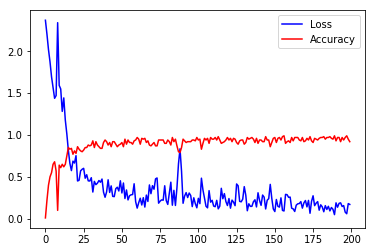

In [7]:
# -------------------Start training--------------------------
# Parameter initialize
workspace.RunNetOnce(train_model.param_init_net)
# Create net
workspace.CreateNet(train_model.net, overwrite=True)

total_iters = 200
accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)

# Manually run the network for 200 iterations
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    accuracy[i] = workspace.blobs['accuracy']
    loss[i] = workspace.blobs['loss']
    
# Plot values
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')
pyplot.show()

In [8]:
# ----------------------------Testing model--------------------------------------------
test_model = model_helper.ModelHelper(name='mnist_test', arg_scope=arg_scope, init_params=False)
data, label = AddInput(test_model, batch_size=100, 
                       db=os.path.join(data_folder, 'mnist-test-nchw-lmdb'), db_type='lmdb')
softmax = AddModel(test_model, data)
AddAccuracy(test_model, softmax, label)

workspace.RunNetOnce(test_model.param_init_net) # use params in workspace to initialize test_model
workspace.CreateNet(test_model.net, overwrite=True)
test_accuracy = np.zeros(100)

# Manually run the network for 100 iterations
for i in range(100):
    workspace.RunNet(test_model.net)
    test_accuracy[i] = workspace.blobs['accuracy']
    
# # Plot values
# pyplot.plot(test_accuracy, 'r')
# pyplot.title('test_accuracy')
# pyplot.show()
print 'test_accuracy:%f' %np.mean(test_accuracy)

test_accuracy:0.953300


The deploy model is saved to: /home/ygj/caffe2/caffe2_notebooks/tutorial_files/tutorial_mnist/mnist_model.minidb
The blobs in the workspace after reset: []
The blobs in the workspace after loading the model: [u'!!META_NET_DEF', u'!!PREDICTOR_DBREADER', u'conv1', u'conv1_b', u'conv1_w', u'conv2', u'conv2_b', u'conv2_w', u'data', u'fc3', u'fc3_b', u'fc3_w', u'pool1', u'pool2', u'pred', u'pred_b', u'pred_w', u'relu3', u'softmax']


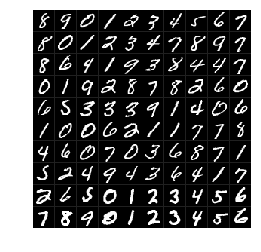

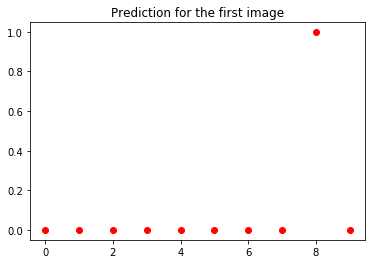

In [10]:
# ---------------------------------------Deploy model--------------------------------------------
deploy_model = model_helper.ModelHelper(name='mnist_deploy', arg_scope=arg_scope, init_params=False)
AddModel(deploy_model,'data')
# Save the deploy model with the trained weights and biases to a file

# construct the model to be exported
# the inputs/outputs of the model are manually specified.
pe_meta = pe.PredictorExportMeta(
    predict_net=deploy_model.net.Proto(),
    parameters=[str(b) for b in deploy_model.params], 
    inputs=["data"],
    outputs=["softmax"],
)

# save the model to a file. Use minidb as the file format
pe.save_to_db("minidb", os.path.join(root_folder, "mnist_model.minidb"), pe_meta)
print("The deploy model is saved to: " + root_folder + "/mnist_model.minidb")

# Load the deploy model and run the prediction to verify it works
# we retrieve the last input data out and use it in our prediction test before we scratch the workspace
blob = workspace.FetchBlob("data")
pyplot.figure()
_ = visualize.NCHW.ShowMultiple(blob)

# reset the workspace, to make sure the model is actually loaded
workspace.ResetWorkspace()

# verify that all blobs are destroyed. 
print("The blobs in the workspace after reset: {}".format(workspace.Blobs()))

# load the predict net
predict_net = pe.prepare_prediction_net(os.path.join(root_folder, "mnist_model.minidb"), "minidb")

# verify that blobs are loaded back
print("The blobs in the workspace after loading the model: {}".format(workspace.Blobs()))

# feed the previously saved data to the loaded model
workspace.FeedBlob("data", blob)

# predict
workspace.RunNetOnce(predict_net)
softmax = workspace.FetchBlob("softmax")

# the first letter should be predicted correctly
pyplot.figure()
_ = pyplot.plot(softmax[0], 'ro')
pyplot.title('Prediction for the first image')
pyplot.show()